<h1> Task 3, Binomial Pricing Model

Fix correct option prices when there is discrete dividends. Fix prepaid prices

In [77]:
import numpy as np 
import matplotlib.pyplot as plt

class BinPriMod:
    def __init__(self, S:float, K:float, sigma:float, total_time:float, period_timespan:float, rate_i:float,
                 option_type:str, exercise_style:str):
        self.spot = S
        self.strike = K
        self.risk = sigma
        self.total_time = total_time
        self.period_time_span = period_timespan
        self.risk_free = rate_i
        self.option_type = option_type
        self.exercise_style = exercise_style
        self.n_periods = int(self.total_time / self.period_time_span)
        self.dividend_yield = None
        self.time_single_div = None
        self.amount_single_div = None
        self.values = None
        self.prices = None
        self.forwards = None


    def help():
        print('def __init__(self, S, K, sigma, T, h, rate_i, option_type, exercise_style):')
        print('\n')
        print('Attributes:\n    up_and_down,\n  storage_values,\n   option_price')

    
    def set_dividends(self, cont=None, cont_rate=None, TD=None, amount=None):
        if cont == True:
            self.dividend_yield = cont_rate
        else:
            self.dividend_yield = cont_rate
            self.time_single_div = TD
            self.amount_single_div = amount

    def up_and_down(self, spot, t):   
        u = np.e**((self.risk_free - self.dividend_yield) * 
                                self.period_time_span) * np.e**(self.risk*np.sqrt(self.period_time_span))
        d = np.e**((self.risk_free -self.dividend_yield) * 
                                self.period_time_span) *np.e**(-self.risk*np.sqrt(self.period_time_span))
        if self.amount_single_div == None:
            uS = spot*u
            dS = spot*d
            return [uS,dS]
        else: 
            pFp = spot - self.amount_single_div*np.e**(-self.risk_free*(self.time_single_div-t))
            div_multiplier = np.e**(-self.risk_free*(self.time_single_div-(t+self.period_time_span)))
            uS = pFp*u + self.amount_single_div*div_multiplier
            dS = pFp*d + self.amount_single_div*div_multiplier
            if self.time_single_div >= t and self.time_single_div <t+self.period_time_span:
                uS = (spot-self.amount_single_div)*u
                dS = (spot-self.amount_single_div)*d
            return [uS, dS]


    def storage_values(self, post=None):
        storage = [[self.spot]]
        for i in range(0, self.n_periods,1):
            sub_storage = []
            for j in range(0, len(storage[i]),2):   
                sub_storage.append(np.array(self.up_and_down(storage[i][j],(i)*self.period_time_span)))
            if (i+1)>=2:
                if (i+1)%2== 0:
                    sub_storage.append(np.reshape(self.up_and_down(storage[i][j+1], (i)*self.period_time_span)[1],(1,)))                                            
            fixed = np.concatenate(sub_storage)
            storage.append(np.round(fixed,3))
        self.values = storage
        if post == True:
            return self.values 

    
    def PrepaidForwad(self, post=None):
        prepfor = []
        for i in range(len(self.values)-1):
            sel_prepfor = []
            for j in range(len(self.values[i])):
                part0 = -self.risk_free*(self.time_single_div-self.period_time_span*i)

                part1 = self.values[i][j] - self.amount_single_div*np.e**(part0)
                # part0 = -self.risk_free*(self.time_single_div-self.period_time_span*i)
                sel_prepfor.append(round(part1,3))
            prepfor.append(sel_prepfor)
        prepfor.append(self.values[-1])
        self.forwards = prepfor
        if post==True:
            return prepfor

# (p*ou + (1-p)*od)*np.e**(0.08/3)

    def option_price(self, 
                     up, down, alt_spot,
                     high_optpri, low_optpri):
        u = up/alt_spot
        d = down/alt_spot
        p = (np.e**((self.risk_free-self.dividend_yield)*self.period_time_span)-d)/(u-d)

        part1 = (self.risk_free-self.dividend_yield)*self.period_time_span
        part2= (p*low_optpri)+((1-p)*high_optpri)

        opt_price = np.e**(part1)*part2

        if self.exercise_style == 'European':
            opt_price = opt_price
        elif self.exercise_style == 'American':
            if self.option_type =='Put':
                opt_price = max(opt_price, self.strike - alt_spot)
            else:
                opt_price = max(opt_price, alt_spot-self.strike)            
        else:
            print('State exercise style!!!')
        return round(opt_price,3)
    

    # def price(up,down,opthigh,optlow,spot):
    #     upr = up/spot
    #     downr = down/spot
    #     p = (np.e**(0.08*1/3)-downr)/(upr-downr)
    #     price = np.e**(-0.08*1/3)*((opthigh*p)+(optlow*(1-p)))
    #     # print(p)
    #     return price
    

    def storage_prices(self, post=None):
        latest_opt_pri = []
        if self.option_type=='Call':
            array = np.where(self.values[self.n_periods]-self.strike>0,self.values[self.n_periods]-self.strike,0)
        elif self.option_type=='Put':
            array = np.where(self.values[self.n_periods]-self.strike<0,self.values[self.n_periods]-self.strike,0)
        else:
            print('State option type!!!')
        latest_opt_pri.append(abs(array))

        for i in range(0, self.n_periods, 1): 
            sub_optpri_storage = []
            for j in range(0,self.n_periods-i,1):   #periods- 1
                if self.forwards != None:
                    relevant = self.forwards
                else: 
                    relevant = self.values
                
                u = relevant[self.n_periods-i][j]
                d = relevant[self.n_periods-i][j+1]
                alt_spot =  relevant[self.n_periods-(i+1)][j]
                sub_optpri_storage.append(self.option_price(u, d, alt_spot,
                                                            latest_opt_pri[i][j], 
                                                            latest_opt_pri[i][j+1]))
            latest_opt_pri.append(np.round(sub_optpri_storage,2))
        # self.prices = np.flip(latest_opt_pri)
        self.prices = latest_opt_pri
        if post == True:
            return self.prices
        return self.prices
         

    def plot_tree(self,txt_shift):
        fig, ax = plt.subplots(figsize=(6,6))
        for i in range(0,int(self.n_periods)+1,1):
            ax.scatter(x=np.repeat((i)*1,i+1), y= self.values[i])
            for j in range(0,i+1,1):
                text_value = 'Value '+ str(self.values[i][j])
                text_price = 'Price '+ str(self.prices[self.n_periods-i][j])
                ax.annotate(text_value, xy=(i*1, self.values[i][j]+txt_shift))
                ax.annotate(text_price, xy=(i*1, self.values[i][j]-txt_shift))
                if self.forwards != None:
                    text_forward = 'PreF. '+ str(self.forwards[i][j])
                    ax.annotate(text_forward, xy=(i*1, self.values[i][j]))

            ax.set_xlabel('Periods')
        ax.set_ylabel('Price')
        plt.xlim(-1,self.n_periods+2*self.period_time_span)
        plt.title('Binomial tree for '+self.exercise_style+' '+self.option_type+' option')
        plt.show()



up, down, spot, highopt, lowpot

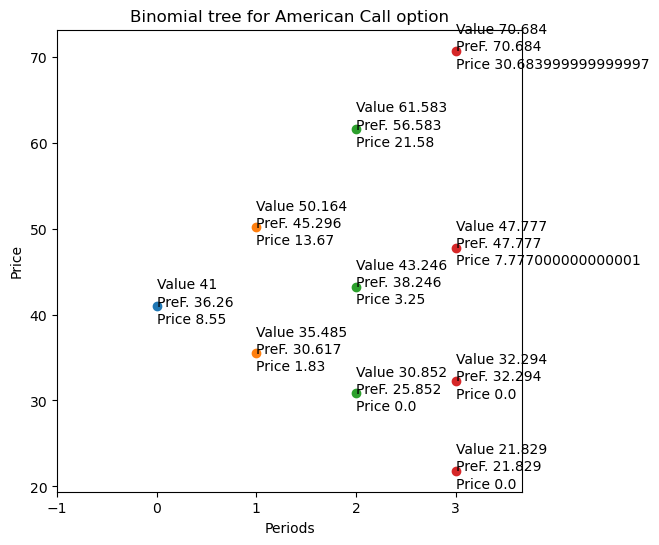

In [79]:
myTree = BinPriMod(41, 40, 0.3392, 1, (1/3), 0.08, 'Call', 'American')
myTree.set_dividends(cont=False, cont_rate=0, TD=8/12, amount=5)
myTree.storage_values(False)
myTree.storage_prices(False)
myTree.PrepaidForwad(False)
myTree.plot_tree(2)

In [80]:
# myTree.values[3]

In [43]:
# myTree = BinPriMod(41, 40, 0.3392, 1, 1/3, 0.08, 'Call', 'American')
# myTree.set_dividends(cont=False, cont_rate=0, TD=8/12, amount=5)
# myTree.storage_values(False)
# myTree.storage_prices(False)
# # myTree.plot_tree(1)

In [11]:
def price(up,down,opthigh,optlow,spot):
    upr = up/spot
    downr = down/spot
    p = (np.e**(0.08*1/3)-downr)/(upr-downr)
    price = np.e**(-0.08*1/3)*((opthigh*p)+(optlow*(1-p)))
    # print(p)
    return price

In [71]:
price(70.686, 47.777, 30.686, 7.777, 61.583-4.6)

NameError: name 'price' is not defined

In [13]:
s = 61.583
e = np.e**(0.08*0.333)
u = 70.684/s
d = 47.777/s
oppe = 30.683*((e-u)/(d-u))
nede = 7.777*((d-e)/(d-u))

# np.e**(-0.08*0.333)*(oppe+nede)


In [14]:
e*(()+())

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
# boy.storage_prices()

In [ ]:
40*np.e**(0.08*0.33+0.33*(0.3392)**0.5)

49.773083960233926

In [ ]:
41*np.e**(0.08*0.333) * np.e**(0.3392*(0.333)**0.5)

51.210845455473915